In [1]:
# simple version of: 
# https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/07_linear_models/02_fama_macbeth.ipynb
# pip install pandas_datareader

### step by step

In [2]:
import pandas as pd
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('whitegrid')

# 获取Fama-French五因子数据（2010-2017） | Fetch Fama-French 5-factor data (2010-2017)
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]

# 获取17个行业投资组合数据 | Fetch 17 industry portfolio data
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]

In [3]:
ff_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-3.35,0.40,0.33,-1.08,0.51,0.00
2010-02,3.39,1.49,3.18,-0.29,1.42,0.00
2010-03,6.30,1.83,2.19,-0.61,1.74,0.01
2010-04,2.00,4.96,2.96,0.61,1.75,0.01
2010-05,-7.90,0.08,-2.48,1.30,-0.24,0.01


In [4]:
ff_portfolio_data.head()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2010-01,-2.06,-12.95,-4.79,-3.63,-3.48,-4.34,-0.46,-2.88,-12.49,-2.76,-7.30,0.39,-2.16,-4.45,-1.28,-0.65,-3.91
2010-02,1.87,12.41,2.29,7.18,9.79,5.78,1.32,6.14,4.48,7.42,7.27,6.60,5.80,-0.42,3.67,2.91,2.54
2010-03,5.08,7.33,3.17,11.25,5.51,7.47,3.24,5.25,11.99,5.00,7.76,8.85,8.99,3.12,6.49,8.31,6.16
2010-04,-1.30,-0.75,4.33,4.92,6.88,2.51,-1.98,10.87,-2.94,3.54,4.82,6.57,2.92,2.85,1.30,1.13,1.40
2010-05,-4.70,-8.00,-10.10,-6.28,-5.41,-10.62,-6.27,-7.85,-7.48,-9.29,-8.06,-7.19,-7.56,-6.30,-5.79,-9.09,-8.03


In [5]:
# 计算超额回报：投资组合回报减去无风险利率 | Calculate excess returns: portfolio returns minus risk-free rate
excess_returns = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)

# 删除无风险利率列，仅保留五个因子 | Drop risk-free rate column, keep only 5 factors
ff_factor_data = ff_factor_data.drop('RF', axis=1)


In [6]:
add_constant(ff_factor_data).head()

,const,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,
2010-01,1.0,-3.35,0.40,0.33,-1.08,0.51
2010-02,1.0,3.39,1.49,3.18,-0.29,1.42
2010-03,1.0,6.30,1.83,2.19,-0.61,1.74
2010-04,1.0,2.00,4.96,2.96,0.61,1.75
2010-05,1.0,-7.90,0.08,-2.48,1.30,-0.24


In [7]:
industry = 'Food'
model = OLS(endog=excess_returns[industry], exog=add_constant(ff_factor_data)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Food   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     30.74
Date:                Wed, 24 Sep 2025   Prob (F-statistic):           4.12e-18
Time:                        12:26:40   Log-Likelihood:                -187.00
No. Observations:                  96   AIC:                             386.0
Df Residuals:                      90   BIC:                             401.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2049      0.193      1.064      0.290      -0.178       0.587
Mkt-RF         0.6713      0.056     11.966      0.000       0.560       0.783
SMB           -0.2898      0.094     -3.067      0.003      -0.477      -0.102
HML           -0.3710      0.109     -3.398      0.001      -0.588      -0.154
RMW            0.3237      0.136      2.376      0.020       0.053       0.594
CMA            0.4718      0.166      2.849      0.005       0.143       0.801
==============================================================================
Omnibus:                       11.645   Durbin-Watson:                   2.535
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.898
Skew:                          -0.646   Prob(JB):                     0.000960
Kurtosis:                       4.344   Cond. No.                         4.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
model.params.drop('const')

Mkt-RF    0.671326
SMB      -0.289772
HML      -0.371029
RMW       0.323681
CMA       0.471759
dtype: float64

In [9]:
betas = []
for industry in excess_returns.columns:
    # 对每个行业投资组合进行时间序列回归 | Time-series regression for each industry portfolio
    model = OLS(endog=excess_returns[industry], exog=add_constant(ff_factor_data)).fit()
    betas.append(model.params.drop('const'))  # 保存因子系数，排除常数项 | Save factor coefficients, exclude constant
betas = pd.DataFrame(betas, columns=ff_factor_data.columns, index=excess_returns.columns)
betas.head()

,Mkt-RF,SMB,HML,RMW,CMA
Food,0.671326,-0.289772,-0.371029,0.323681,0.471759
Mines,1.355268,0.180573,0.214317,0.284986,0.551000
Oil,1.044388,0.169541,0.648761,0.000857,0.329002
Clths,0.978757,0.371904,-0.161877,0.620688,0.014485
Durbl,1.171181,0.579098,0.072743,0.523549,-0.088648


In [10]:
period = '2010-01'
model = OLS(endog=excess_returns.loc[period], exog=betas).fit()
model.summary()

/Users/test1/py_env/rpa/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                2010-01   R-squared (uncentered):                   0.786
Model:                            OLS   Adj. R-squared (uncentered):              0.697
Method:                 Least Squares   F-statistic:                              8.831
Date:                Wed, 24 Sep 2025   Prob (F-statistic):                     0.00103
Time:                        12:26:40   Log-Likelihood:                         -39.855
No. Observations:                  17   AIC:                                      89.71
Df Residuals:                      12   BIC:                                      93.88
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        -3.3037      1.026     -3.220      0.007      -5.539      -1.068
SMB            3.8711      3.512      1.102      0.292      -3.781      11.523
HML           -6.3988      2.967     -2.157      0.052     -12.863       0.065
RMW           -4.9287      3.464     -1.423      0.180     -12.475       2.618
CMA           -3.3327      2.615     -1.275      0.227      -9.029       2.364
==============================================================================
Omnibus:                        2.291   Durbin-Watson:                   2.403
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                1.780
Skew:                          -0.744   Prob(JB):                        0.411
Kurtosis:                       2.453   Cond. No.                         7.35
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# 第二步：估计风险溢价（lambda） | Step 2: Estimate risk premia (lambdas)
lambdas = []
for period in excess_returns.index:
    # 对每个时间点进行横截面回归 | Cross-sectional regression for each time period
    model = OLS(endog=excess_returns.loc[period], exog=betas).fit()
    lambdas.append(model.params)  # 保存风险溢价 | Save risk premia
lambdas = pd.DataFrame(lambdas, index=excess_returns.index, columns=betas.columns)
lambdas.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-3.303680,3.871125,-6.398814,-4.928720,-3.332658
2010-02,3.801168,5.478508,-1.068688,2.015468,-0.607710
2010-03,6.245360,-0.380457,0.009616,2.868186,-1.892250
2010-04,1.746755,8.610898,-4.246731,-2.726976,-1.856080
2010-05,-7.723654,2.575496,-0.031722,1.825281,-0.229150


### merge

因子风险溢价均值 | Mean Risk Premia:
Mkt-RF    1.173875
SMB       0.159125
HML      -1.251284
RMW      -0.488108
CMA      -0.469043
dtype: float64

T统计量 | T-statistics:
Mkt-RF    0.326451
SMB       0.041493
HML      -0.297173
RMW      -0.162630
CMA      -0.140850
dtype: float64


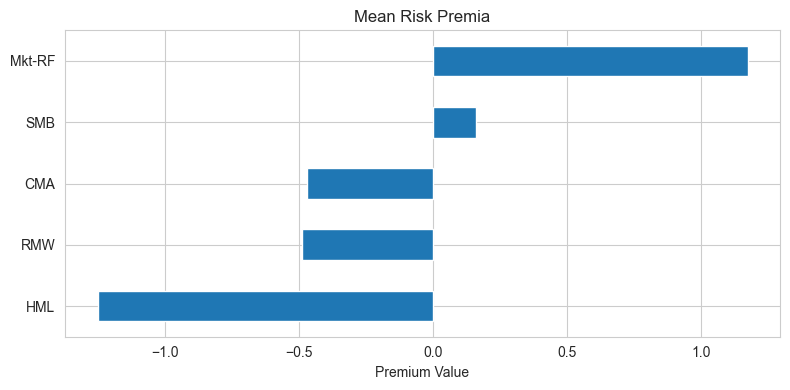

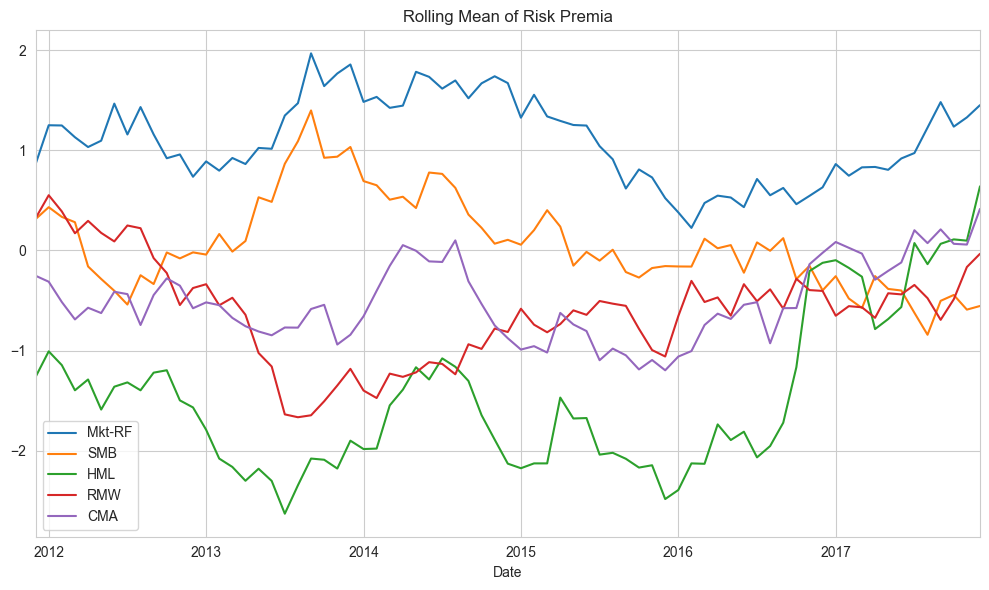

In [12]:
# 导入必要的库 | Import necessary libraries
import pandas as pd
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('whitegrid')

# 获取Fama-French五因子数据（2010-2017） | Fetch Fama-French 5-factor data (2010-2017)
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]

# 获取17个行业投资组合数据 | Fetch 17 industry portfolio data
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]

# 计算超额回报：投资组合回报减去无风险利率 | Calculate excess returns: portfolio returns minus risk-free rate
excess_returns = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)

# 删除无风险利率列，仅保留五个因子 | Drop risk-free rate column, keep only 5 factors
ff_factor_data = ff_factor_data.drop('RF', axis=1)

# 第一步：估计因子暴露（beta） | Step 1: Estimate factor exposures (betas)
betas = []
for industry in excess_returns.columns:
    # 对每个行业投资组合进行时间序列回归 | Time-series regression for each industry portfolio
    model = OLS(endog=excess_returns[industry], exog=add_constant(ff_factor_data)).fit()
    betas.append(model.params.drop('const'))  # 保存因子系数，排除常数项 | Save factor coefficients, exclude constant
betas = pd.DataFrame(betas, columns=ff_factor_data.columns, index=excess_returns.columns)

# 第二步：估计风险溢价（lambda） | Step 2: Estimate risk premia (lambdas)
lambdas = []
for period in excess_returns.index:
    # 对每个时间点进行横截面回归 | Cross-sectional regression for each time period
    model = OLS(endog=excess_returns.loc[period], exog=betas).fit()
    lambdas.append(model.params)  # 保存风险溢价 | Save risk premia
lambdas = pd.DataFrame(lambdas, index=excess_returns.index, columns=betas.columns)

# 计算风险溢价均值和t统计量 | Calculate mean risk premia and t-statistics
lambda_means = lambdas.mean()
t_stats = lambda_means / lambdas.std()

# 打印结果 | Print results
print("因子风险溢价均值 | Mean Risk Premia:")
print(lambda_means)
print("\nT统计量 | T-statistics:")
print(t_stats)

# 可视化风险溢价均值 | Visualize mean risk premia
plt.figure(figsize=(8, 4))
lambda_means.sort_values().plot.barh()
plt.title('Mean Risk Premia')  # 因子风险溢价均值
plt.xlabel('Premium Value')   # 溢价值
plt.tight_layout()
plt.show()

# 可视化风险溢价随时间变化（24个月滚动均值） | Visualize risk premia over time (24-month rolling mean)
lambdas.rolling(24).mean().dropna().plot(figsize=(10, 6), title='Rolling Mean of Risk Premia')  # 风险溢价滚动均值
plt.tight_layout()
plt.show()

In [13]:
# pip install linearmodels
from linearmodels.asset_pricing import LinearFactorModel
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6893
No. Factors:                          5   J-statistic:                    15.783
No. Observations:                    96   P-value                         0.2014
Date:                  Wed, Sep 24 2025   Distribution:                 chi2(12)
Time:                          12:26:46                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.1864     0.4111     2.8856     0.0039      0.3806      1.9922
SMB            0.1528     0.8464    